In [2]:
# import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, label_binarize
import joblib

from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#### Load Ensemble Model trained from 2000 cohort dataset 

In [3]:
path="/Users/Hp/Desktop/3000_cohort_analysis/"
with open(path + 'ensemble_model_2000_cohort_16_full_support_with_covariates_1', 'rb') as f1: 
    ensemble_model = joblib.load(f1)
model_ensemble = ensemble_model

#### Load validation dataset from 3000 cohort dataset 

In [4]:
# import dataset for validation
path="/Users/Hp/Desktop/3000_cohort_analysis/"
df_2 = pd.read_csv(path+"feature_count_16_full_supported_variants_latest_3000_cohort_arranged_updated.csv", delimiter=',', quotechar='"', index_col='sample_ID')

df_2.head()

,age,gender,grouping,BMS1P1;FRMPD2B,CEP131,CNTFR,GFM1,GOLGA6L3,HDGFL2,LOC100996720,MIR933,PCSK5,PLEC,SECISBP2L,SPATA6,TRIM72,ZBED3,ZBTB3,ZRANB3
sample_ID,,,,,,,,,,,,,,,,,,,
AR-COVID3-USC-AREZZO_hg38,29,1,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0
BS-COV-56_hg38,32,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
BS-COV-83_hg38,34,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0
COV10001-3742_hg38,67,1,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0
COV10013-3746_hg38,71,0,1,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0


In [8]:
# prepare the dataset

# define target variable 
y_val = df_2['grouping']

# define target variable 
target = df_2['grouping']
# features 
X_val = df_2.drop('grouping', 1)

In [9]:
#Binarize the target variable and scale

scaler = StandardScaler()

# training set
scale = StandardScaler()
X_va = pd.DataFrame(scale.fit_transform(X_val))
X_va.columns = X_val.columns.values
X_va.index = X_val.index.values
X_val = X_va

y_val = label_binarize(y_val, classes=[0, 1])

In [7]:
X_val.columns

Index(['age', 'gender', 'BMS1P1;FRMPD2B', 'CEP131', 'CNTFR', 'GFM1',
       'GOLGA6L3', 'HDGFL2', 'LOC100996720', 'MIR933', 'PCSK5', 'PLEC',
       'SECISBP2L', 'SPATA6', 'TRIM72', 'ZBED3', 'ZBTB3', 'ZRANB3'],
      dtype='object')

#### Make Predictions 

In [10]:
# calculate model accuracy decision tree like models fold_1_5, 2000 cohort 
from sklearn.metrics import accuracy_score
y_pred = ensemble_model.predict(X_val)
print('Test Accuracy score %s' % accuracy_score(y_val, y_pred))

Test Accuracy score 0.7799352750809061


In [12]:
# predict probabilities
model = ensemble_model
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef
es_probs = model.predict_proba(X_val)
# keep probabilities for the positive outcome only
es_probs = es_probs[:, 1]

# predict class values
y_pred = model.predict(X_val)
# calculate precision and recall for each threshold
es_precision, es_recall, _ = precision_recall_curve(y_val, es_probs)
# calculate scores
es_f1, es_auc = f1_score(y_val, y_pred), auc(es_recall, es_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (es_f1, es_auc))

Logistic: f1=0.845 auc=0.968


#### Visualize Precision-Recall ROC-Curve 

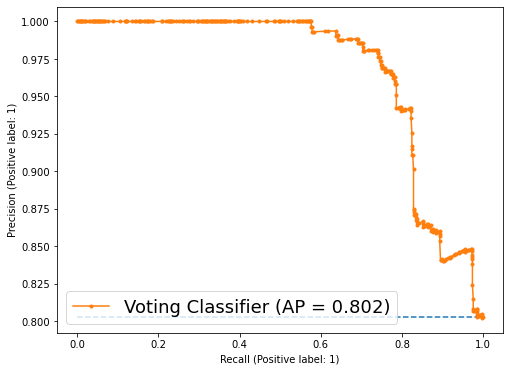

In [15]:
# plot the precision-recall curves
import matplotlib.pyplot as plt
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
no_severe = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0, 1], [no_severe, no_severe], linestyle='--')
pyplot.plot(es_recall, es_precision, marker='.', label='Voting Classifier (AP = 0.802)')

#fig.suptitle('VotingClassifier Classification Report', fontsize=20)
#[t.set_color('black') for t in ax.xaxis.get_ticklines()]
#[t.set_color('black') for t in ax.xaxis.get_ticklabels()]
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
# axis labels
pyplot.xlabel('Recall (Positive label: 1)')
pyplot.ylabel('Precision (Positive label: 1)')
# show the legend
pyplot.legend()
plt.legend(loc='lower left')
#plt.savefig(path+'PR_ROC_3000_Cohort_decision_tree_like_models.pdf', bbox_inches='tight')
#plt.savefig(path+'PR_ROC_3000_Cohort_decision_tree_like_models.jpg', bbox_inches='tight')
# show the plot
pyplot.show()

#### Visualize ROC Curve 

Asymptomatic: ROC AUC=0.500
Voting Classifier: ROC AUC=0.864


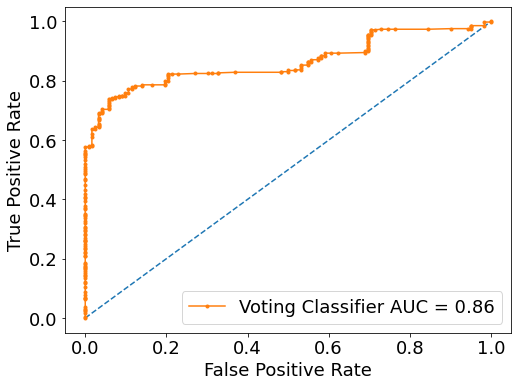

In [16]:
### ROC Curve 
from sklearn.metrics import roc_auc_score, roc_curve
# generate a no ensemble voting classifier prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
es_auc = roc_auc_score(y_val, es_probs)
# summarize scores
print('Asymptomatic: ROC AUC=%.3f' % (ns_auc))
print('Voting Classifier: ROC AUC=%.3f' % (es_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
es_fpr, es_tpr, _ = roc_curve(y_val, es_probs)
# plot the roc curve for the model
fig = plt.figure(figsize=(8, 6))
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(es_fpr, es_tpr, marker='.', label='Voting Classifier AUC = %0.2f' % es_auc)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
#plt.legend(loc='lower left')
#plt.savefig(path+'AUC_ROC_3000_Cohort_decision_tree_like_models.pdf', bbox_inches='tight')
#plt.savefig(path+'AUC_ROC_3000_Cohort_decision_tree_like_models.jpg', bbox_inches='tight')
# show the plot
pyplot.show()

#### Visualize the Confusion Matrix 

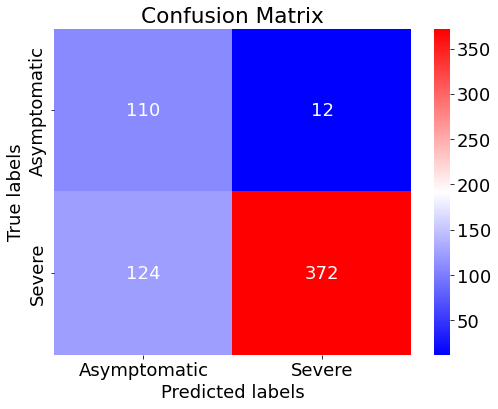

In [18]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

class_name = ['Asymptomatic', 'Severe']
fig = plt.figure(figsize=(8, 6))

confusion_matrix(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=plt.cm.bwr, ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Asymptomatic', 'Severe']); ax.yaxis.set_ticklabels(['Asymptomatic', 'Severe']);

#plt.savefig(path+'confusion_matrix_3000_Cohort_decision_tree_like_models.pdf', bbox_inches='tight')
#plt.savefig(path+'confusion_matrix_3000_Cohort_decision_tree_like_models.jpg', bbox_inches='tight')

#### Classifier Metrics Evaluation

Classification models attempt to predict a target in a discrete space, that is assign an instance of dependent variables one or more categories. Classification score visualizers display the differences between classes as well as a number of classifier-specific visual evaluations.


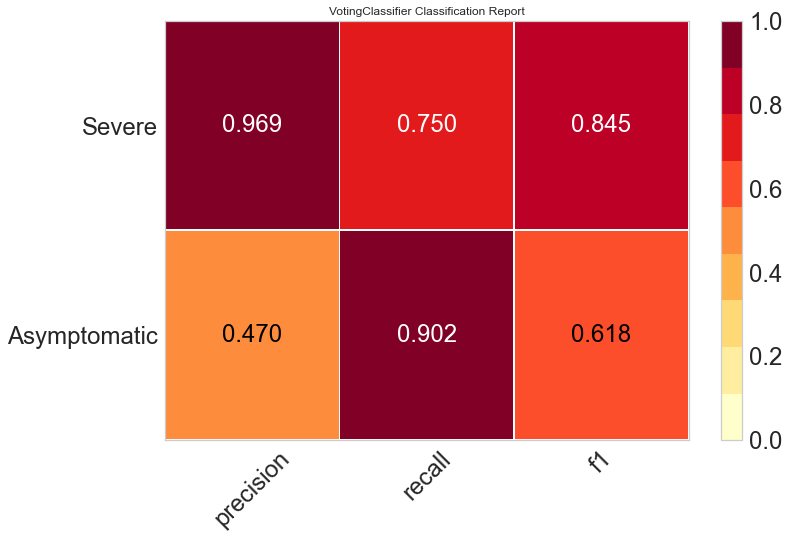

In [20]:
from yellowbrick.classifier import ClassificationReport, ROCAUC, ClassBalance
import matplotlib 
plt.figure(figsize=(12, 8))
#fig = plt.figure()
visualizer = ClassificationReport(model, classes=class_name)
matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 
#fig.suptitle('VotingClassifier Classification Report', fontsize=20)
matplotlib.rcParams.update({'font.size': 24})
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()  

### COVID-19 Host Severity Predictor Model Explanation

We utilized the explainerdashboard python package. This approach makes it easy to quickly build an interactive dashboard that explains the inner workings of our developed ensemble COVID-19 host severity predictor model. This allows us to open up the 'black box' to further shed more light to our understanding of how exactly our developed ensemble COVID-19 host severity predictor model generates its predictions on the 3000 cohort dataset.

#### Define Feature Description Integrated with Phenome-wide Associated disease traits 

In [21]:
feature_descriptions = {"age" : "Age (Years)", "gender" : "Gender",
                        "ZBED3" : "ZBED3(rs531117283)[Hint: Genetic disease associated - BMI-adjusted waist-hip ratio, type 2 diabetes mellitus]", 
                        "PLEC" : "PLEC(rs140300753) [Hint: Genetic disease associated - Abnormalities of breathing, Epidermolysis bullosa simplex with muscular dystrophy, Epidermolysis bullosa simplex with pyloric atresia]",
                        "TRIM72" : "TRIM72() [Hint: Genetic disease associated - breast adenocarcinoma, diabetes mellitus, coronary artery disease]", 
                        "HDGFL2" : "HDGFL2(rs146793578) [Hint: Genetic disease associated - mean corpuscular hemoglobin concentration, BMI-adjusted waist-hip ratio, smoking status measurement]", 
                        "SECISBP2L" : "SECISBP2L(rs75595801) [Hint: Genetic disease associated - calcium measurement, diastolic blood pressure, lung adenocarcinoma, alcohol consumption measurement]",
                        "CEP131" : "CEP131(rs2659015)[Hint: Genetic disease associated - serum IgG glycosylation measurement, brain glioblastoma, IgG fucosylation measurement, vitamin D measurement]",
                        "GOLGA6L3" : "GOLGA6L3(rs367838829) [Hint:Genetic disease - BMI-adjusted waist and hip circumference]",
                        "PCSK5" : "PCSK5(rs72745135) [Hint: Genetic disease associated - Abnormalities of breathing, Currarino Syndrome and Avian Influenza.]",
                        "GFM1" : "GFM1(rs370496368) [Hint:Genetic disease associated - Hepatoencephalopathy due to combined oxidative phosphorylation deficiency type 1, combined oxidative phosphorylation deficiency, systolic blood pressure]", 
                        "ZBTB3" : "ZBTB3(rs544641)[Hint: Genetic disease associated - alcohol consumption measurement, wellbeing measurement, chronotype measurement]",
                        "BMS1P1;FRMPD2B" : "BMS1P1;FRMPD2B()", "SPATA6" : "SPATA6(rs77303590) [Hint: Genetic disease associated - urinary metabolite measurement, systolic blood pressure]",
                        "CNTFR" : "CNTFR() [Hint: Genetic disease associated - blood protein measurement, heel bone mineral density, adolescent idiopathic scoliosis]", "MIR933" : "MIR933(rs79402775)", 
                        "ZRANB3" : "ZRANB3(rs1465146591)[Hint: Genetic disease associated - body height, gut microbiome measurement, body mass index]",
                        "LOC100996720" : "LOC100996720()"
                       }
                        

In [22]:
### Explainer model 
explainer = ClassifierExplainer(ensemble_model, X_val, y_val.ravel(), 
                                descriptions=feature_descriptions, # adds a table and hover labels to dashboard
                                labels=['Asymptomatic', 'Severe'], # defaults to ['0', '1', etc]
                                idxs = X_val.index, # defaults to X.index
                                index_name = "sample_ID", # defaults to X.index.name
                                target = "grouping", # defaults to y.name
                                )

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')


In [24]:
db = ExplainerDashboard(explainer, 
  title="An Explainable Model of Host Genetic interactions linked to COVID-19 severity in patients", # defaults to "Model Explainer"
  whatif=False, mode='inline')
db.run(port=8050)

Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...



Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8050))
